In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install yfinance

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf

from keras import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime, timedelta, timezone
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1. One Step Forecast of Two Stocks

In [0]:
# Chosen symbols

symbols=["MSFT", "BAC"] # Microsoft and Bank of America

In [0]:
# Loading data

price=yf.download(symbols, start="2016-01-01", end="2019-09-18", interval="1d", prepost=True)

[*********************100%***********************]  2 of 2 downloaded


In [0]:
price.head(3)

Adj Close         Close         ...   Open            Volume          
                 BAC   MSFT    BAC   MSFT  ...    BAC   MSFT        BAC      MSFT
Date                                       ...                                   
2016-01-04     15.37  50.71  16.43  54.80  ...  16.45  54.32  114888000  53778000
2016-01-05     15.37  50.94  16.43  55.05  ...  16.52  54.93   66670000  34079700
2016-01-06     15.05  50.01  16.08  54.05  ...  16.19  54.32  102760800  39518900

[3 rows x 12 columns]

In [0]:
# Data Seperation of Symbols

bac_raw=price.xs('BAC', level=1, axis=1)
ms_raw =price.xs("MSFT", level=1, axis=1)

In [0]:
# Adding a new feature named as "Change"
# Dropping first value which is wrong
# Dropping unused columns

bac_raw["Avg"]=(bac_raw["Adj Close"] + bac_raw["Adj Close"]) / 2
bac_raw=bac_raw.drop(bac_raw.index[0], axis=0)
bac_raw=bac_raw.drop(bac_raw.iloc[:,0:5], axis=1)

ms_raw["Avg"]=(ms_raw["Adj Close"] + ms_raw["Adj Close"]) / 2
ms_raw=ms_raw.drop(ms_raw.index[0], axis=0)
ms_raw=ms_raw.drop(ms_raw.iloc[:,0:5], axis=1)

In [0]:
bac_raw.head()

,Volume,Avg
Date,,
2016-01-05,66670000,15.37
2016-01-06,102760800,15.05
2016-01-07,116255900,14.50
2016-01-08,124782400,14.22
2016-01-11,104611700,14.33


In [0]:
bac=MinMaxScaler(feature_range=(0,1)).fit_transform(bac_raw)

ms=MinMaxScaler(feature_range=(0,1)).fit_transform(ms_raw)

In [0]:
bac=np.array(bac)

ms=np.array(ms)

In [0]:
# Preparing X and y

duration=50

X_bac, y_bac, X_ms, y_ms=[], [], [], []

for i in range(0, len(bac)-duration):
  a=bac[i:i+duration]
  b=ms[i:i+duration]

  X_bac.append(a)
  X_ms.append(b)

  y_bac.append(bac[i+duration][1])
  y_ms.append(ms[i+duration][1])

In [0]:
# Reorganising the datasets

X_bac=np.reshape(X_bac, (np.shape(X_bac)[0], np.shape(X_bac)[1], np.shape(X_bac)[2]))
y_bac=np.reshape(y_bac, (np.shape(y_bac)[0], 1))

X_ms=np.reshape(X_ms, (np.shape(X_ms)[0], np.shape(X_ms)[1], np.shape(X_ms)[2]))
y_ms=np.reshape(y_ms, (np.shape(y_ms)[0], 1))

In [0]:
# Splitting into train and test subdatasets

percentage=0.3

test_size=int(percentage*len(X_ms))

# Bank of America (train)
X_bac_tr=X_bac[0:len(X_bac)-test_size]
y_bac_tr=y_bac[0:len(y_bac)-test_size]

# Bank of America (test)
X_bac_test=X_bac[len(X_bac)-test_size:len(X_bac)]
y_bac_test=y_bac[len(y_bac)-test_size:len(X_bac)]

# Microsoft (train)
X_ms_tr=X_ms[0:len(X_ms)-test_size]
y_ms_tr=y_ms[0:len(y_ms)-test_size]

# Microsoft (test)
X_ms_test=X_ms[len(X_ms)-test_size:len(X_ms)]
y_ms_test=y_ms[len(y_ms)-test_size:len(X_ms)]

In [0]:
# Modelling, compiling and fitting (Bank of America)

model_bac_1=Sequential()

model_bac_1.add(LSTM(units=40, return_sequences=True, input_shape=(np.shape(X_bac_tr)[1], np.shape(X_bac_tr)[2])))
model_bac_1.add(LSTM(units=40))
model_bac_1.add(Dense(units=1))

model_bac_1.compile(loss="mean_squared_error", optimizer="adam")

model_bac_1.fit(X_bac_tr, y_bac_tr, epochs=1000, validation_split=0.2, batch_size=256, verbose=0)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
# Modelling, compiling and fitting (Microsoft)

model_ms_1=Sequential()

model_ms_1.add(LSTM(units=40, return_sequences=True, input_shape=(np.shape(X_ms_tr)[1], np.shape(X_ms_tr)[2])))
model_ms_1.add(LSTM(units=40))
model_ms_1.add(Dense(units=1))

model_ms_1.compile(loss="mean_squared_error", optimizer="adam")

model_ms_1.fit(X_ms_tr, y_ms_tr, epochs=1000, validation_split=0.2, batch_size=256, verbose=0)

In [0]:
# Prediction on test datasets

pred_bac_1=model_bac_1.predict(X_bac_test)

pred_ms_1=model_ms_1.predict(X_ms_test)

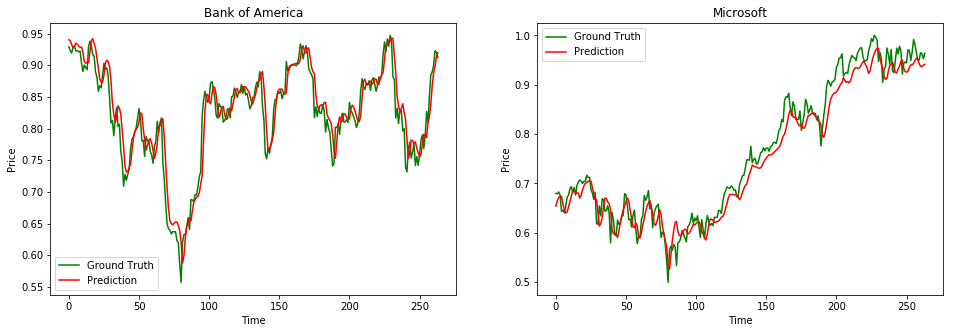

In [0]:
# Plotting the results

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(y_bac_test, color='green', label="Ground Truth")
plt.plot(pred_bac_1, color= 'red', label="Prediction")
plt.title("Bank of America")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_ms_test, color='green', label="Ground Truth")
plt.plot(pred_ms_1, color= 'red', label="Prediction")
plt.title("Microsoft")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.show()

## 2. Problems of RNN's

There are 2 main problems for RNN's.

1. EXPLODING GRADIENT: Values bigger than 1 in weight matrix result in too big values while vector production. This causes optimization become nearly impossible.

2. VANISHING GRADIENT: Values smaller than 1 in weight matrix result in convergence to zero while vector production. This causes gradient to disappear and hand in nothing.

## 3. Epoch and Batch Change

EPOCH is the cycle of the model. On each epoch, the model learns a bit more. If the model is not trained enough (low epoch values), results will not be as accurate as desired. Too big epoch values result in too long time to be reasonable for a little model.

BATCH SIZE is the amount of data points processed at a time. Small size causes too long time to train, big size causes low prediction accuracy.

Some parameters are changed belove.

Check the results.

In [0]:
# Modelling, compiling and fitting (Bank of America)

model_bac_2=Sequential()

model_bac_2.add(LSTM(units=30, return_sequences=True, input_shape=(np.shape(X_bac_tr)[1], np.shape(X_bac_tr)[2])))
model_bac_2.add(LSTM(units=30))
model_bac_2.add(Dense(units=1))

model_bac_2.compile(loss="mean_squared_error", optimizer="adam")

model_bac_2.fit(X_bac_tr, y_bac_tr, epochs=100, validation_split=0.2, batch_size=64, verbose=0)



# Modelling, compiling and fitting (Microsoft)

model_ms_2=Sequential()

model_ms_2.add(LSTM(units=30, return_sequences=True, input_shape=(np.shape(X_ms_tr)[1], np.shape(X_ms_tr)[2])))
model_ms_2.add(LSTM(units=30))
model_ms_2.add(Dense(units=1))

model_ms_2.compile(loss="mean_squared_error", optimizer="adam")

model_ms_2.fit(X_ms_tr, y_ms_tr, epochs=100, validation_split=0.2, batch_size=64, verbose=0)

In [0]:
# Prediction on test datasets

pred_bac_2=model_bac_2.predict(X_bac_test)

pred_ms_2=model_ms_2.predict(X_ms_test)

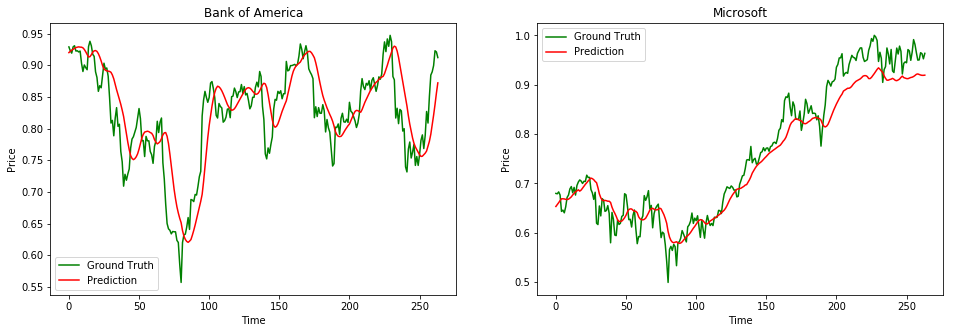

In [0]:
# Plotting the results

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(y_bac_test, color='green', label="Ground Truth")
plt.plot(pred_bac_2, color= 'red', label="Prediction")
plt.title("Bank of America")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_ms_test, color='green', label="Ground Truth")
plt.plot(pred_ms_2, color= 'red', label="Prediction")
plt.title("Microsoft")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.show()